In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import catboost
import xgboost
import optuna
import pickle

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")

In [51]:
data = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv')
data.describe()

,id,ltd,ltm,total_replenishment_lt,total_replenishment_pd,cash_expenditure_pd,services_count_pd,amount,duration,npl_days,current_installments_sum,age_pd,current_debt_lt,nps_lt,support_requests_pd,recency_segment_lt,monetary_segment_lt,frequency_segment_lt,avg_check_reviews_lt,avg_daily_reviews_lt,avg_amount_reviews_lt,rating_reviews_lt,avg_check_categories_pd,avg_check_reviews_pd,responses_per_day_pd,connects_per_day_pd,calls_per_day_pd,hires_per_day_pd,review_requests_per_day_pd,reviews_per_day_pd,daily_amount_responses_pd,daily_amount_connects_pd,daily_amount_calls_pd,daily_amount_hires_pd,daily_amount_review_requests_pd,daily_amount_reviews_pd,rating_reviews_pd,avg_responses_requests_cpd,avg_responses_responder_cpd,avg_requests_responder_cpd,daily_amount_requests_responder_cpd,daily_amount_requests_connects_cpd,paid_period_proportion_pd,responder_period_proportion_pd,connect_period_proportion_pd,catalog_responses_proportion_pd,target,Cluster,year,month,day,year_opened,month_opened,day_opened
count,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000
mean,252531.0241,720.0084,24.4869,125604.9613,57816.1154,57668.4758,7.5633,2353.5049,14.9152,42.4100,0.0000,35.1526,49739.2229,2.4403,11.9956,4.5495,2.3083,3.1221,27231.5712,0.0723,1247.3653,4.9027,28097.7032,19915.9470,4.0254,1.8228,1.7977,0.1098,0.1098,0.1178,81822.4128,36233.0793,36523.0412,1579.8219,1440.7213,1791.8289,3.7789,6.0038,0.3255,0.0583,1866.0236,2538.2097,53.3120,46.3283,39.1408,0.1872,0.2393,1.8243,2021.8555,6.4654,15.7167,2019.9017,6.2408,16.1035
std,204687.4280,492.1116,16.4085,232241.3137,181297.0235,181629.8380,6.6226,3277.1073,8.5503,95.5468,0.0000,7.8320,133905.6440,4.2143,27.2312,1.0688,0.9533,1.2273,30758.6102,0.1026,1515.3542,0.5048,22527.4851,31931.1252,4.9425,2.7532,2.6536,0.2369,0.2508,0.2168,125117.4404,57763.3298,61733.7983,2699.4868,2792.4542,2607.9005,2.1194,2.4545,0.1321,0.0268,1909.0321,2403.2924,31.3081,29.0870,28.3281,0.2293,0.4267,1.1507,0.7819,3.8075,8.7796,1.3367,3.5138,8.6964
min,794.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,50.0000,10.0000,0.0000,0.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2021.0000,1.0000,1.0000,2016.0000,1.0000,1.0000
25%,93389.0000,337.0000,12.0000,11098.7500,2500.0000,2350.0000,3.0000,750.0000,10.0000,0.0000,0.0000,29.0000,0.0000,0.0000,0.0000,5.0000,2.0000,2.0000,10870.1112,0.0140,314.2053,5.0000,13400.0000,7060.1429,0.7333,0.2889,0.2778,0.0000,0.0000,0.0111,15455.1389,5934.1667,5568.3333,0.0000,0.0000,108.3333,4.0000,4.0947,0.2358,0.0402,707.9439,1058.0660,25.0000,22.2222,15.5556,0.0238,0.0000,1.0000,2021.0000,3.0000,8.0000,2019.0000,3.0000,9.0000
50%,178620.0000,649.0000,22.0000,34000.0000,8000.0000,7560.0000,5.0000,1250.0000,10.0000,8.0000,0.0000,34.0000,10572.7750,0.0000,1.0000,5.0000,2.0000,3.0000,14835.9063,0.0364,800.6373,5.0000,19062.5000,11550.0000,2.1000,0.8112,0.8222,0.0222,0.0111,0.0333,47674.5000,19071.9444,18512.5000,468.7500,222.2222,719.4444,5.0000,5.7141,0.3444,0.0536,1103.3671,1621.3212,55.0000,44.4444,34.4444,0.0906,0.0000,2.0000,2022.0000,7.0000,16.0000,2020.0000,6.0000,16.0000
75%,353628.0000,984.2500,33.0000,120611.2500,24500.0000,23947.7500,11.0000,2730.0000,15.0000,29.0000,0.0000,41.0000,41217.6250,4.0000,8.0000,5.0000,2.0000,4.0000,366

In [52]:
data.shape

(22056, 64)

In [53]:
columns_to_drop = ['data_collection_date',
 'work_start_date',
 'phone_number',
 'installment_status',
 'current_installments_sum',
 'nps_lt',
 'selected_service_categories_lt',
 'monetary_segment_lt',
 'Cluster']

data = data.drop(columns_to_drop,axis=1)

In [54]:
data = data.drop_duplicates()
print(data.shape)
data.describe()

(22056, 55)


,id,ltd,ltm,total_replenishment_lt,total_replenishment_pd,cash_expenditure_pd,services_count_pd,amount,duration,npl_days,age_pd,current_debt_lt,support_requests_pd,recency_segment_lt,frequency_segment_lt,avg_check_reviews_lt,avg_daily_reviews_lt,avg_amount_reviews_lt,rating_reviews_lt,avg_check_categories_pd,avg_check_reviews_pd,responses_per_day_pd,connects_per_day_pd,calls_per_day_pd,hires_per_day_pd,review_requests_per_day_pd,reviews_per_day_pd,daily_amount_responses_pd,daily_amount_connects_pd,daily_amount_calls_pd,daily_amount_hires_pd,daily_amount_review_requests_pd,daily_amount_reviews_pd,rating_reviews_pd,avg_responses_requests_cpd,avg_responses_responder_cpd,avg_requests_responder_cpd,daily_amount_requests_responder_cpd,daily_amount_requests_connects_cpd,paid_period_proportion_pd,responder_period_proportion_pd,connect_period_proportion_pd,catalog_responses_proportion_pd,target,year,month,day,year_opened,month_opened,day_opened
count,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000
mean,252531.0241,720.0084,24.4869,125604.9613,57816.1154,57668.4758,7.5633,2353.5049,14.9152,42.4100,35.1526,49739.2229,11.9956,4.5495,3.1221,27231.5712,0.0723,1247.3653,4.9027,28097.7032,19915.9470,4.0254,1.8228,1.7977,0.1098,0.1098,0.1178,81822.4128,36233.0793,36523.0412,1579.8219,1440.7213,1791.8289,3.7789,6.0038,0.3255,0.0583,1866.0236,2538.2097,53.3120,46.3283,39.1408,0.1872,0.2393,2021.8555,6.4654,15.7167,2019.9017,6.2408,16.1035
std,204687.4280,492.1116,16.4085,232241.3137,181297.0235,181629.8380,6.6226,3277.1073,8.5503,95.5468,7.8320,133905.6440,27.2312,1.0688,1.2273,30758.6102,0.1026,1515.3542,0.5048,22527.4851,31931.1252,4.9425,2.7532,2.6536,0.2369,0.2508,0.2168,125117.4404,57763.3298,61733.7983,2699.4868,2792.4542,2607.9005,2.1194,2.4545,0.1321,0.0268,1909.0321,2403.2924,31.3081,29.0870,28.3281,0.2293,0.4267,0.7819,3.8075,8.7796,1.3367,3.5138,8.6964
min,794.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,50.0000,10.0000,0.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2021.0000,1.0000,1.0000,2016.0000,1.0000,1.0000
25%,93389.0000,337.0000,12.0000,11098.7500,2500.0000,2350.0000,3.0000,750.0000,10.0000,0.0000,29.0000,0.0000,0.0000,5.0000,2.0000,10870.1112,0.0140,314.2053,5.0000,13400.0000,7060.1429,0.7333,0.2889,0.2778,0.0000,0.0000,0.0111,15455.1389,5934.1667,5568.3333,0.0000,0.0000,108.3333,4.0000,4.0947,0.2358,0.0402,707.9439,1058.0660,25.0000,22.2222,15.5556,0.0238,0.0000,2021.0000,3.0000,8.0000,2019.0000,3.0000,9.0000
50%,178620.0000,649.0000,22.0000,34000.0000,8000.0000,7560.0000,5.0000,1250.0000,10.0000,8.0000,34.0000,10572.7750,1.0000,5.0000,3.0000,14835.9063,0.0364,800.6373,5.0000,19062.5000,11550.0000,2.1000,0.8112,0.8222,0.0222,0.0111,0.0333,47674.5000,19071.9444,18512.5000,468.7500,222.2222,719.4444,5.0000,5.7141,0.3444,0.0536,1103.3671,1621.3212,55.0000,44.4444,34.4444,0.0906,0.0000,2022.0000,7.0000,16.0000,2020.0000,6.0000,16.0000
75%,353628.0000,984.2500,33.0000,120611.2500,24500.0000,23947.7500,11.0000,2730.0000,15.0000,29.0000,41.0000,41217.6250,8.0000,5.0000,4.0000,36650.4836,0.0931,1644.8036,5.0000,36125.0000,20000.0000,5.1000,1.9667,1.9667,0.0778,0.0778,0.1011,111405.8333,46872.9167,47982.2500,1666.6667,1444.4444,2291.6667,5.0000,7.4082,0.4197,0.0736,2306.7851,3141.8462,81.0000,68.8889,58.8889,0.2676,0.0000,2022.0000,10.0000,2

In [55]:
data = data[['total_replenishment_lt',
 'total_replenishment_pd',
 'current_debt_lt',
 'hires_per_day_pd',
 'cash_expenditure_pd',
 'daily_amount_calls_pd',
 'support_requests_pd',
 'catalog_responses_proportion_pd',
 'amount','duration',
 'paid_period_proportion_pd',
 'avg_check_reviews_lt',
 'avg_responses_responder_cpd',
 'avg_daily_reviews_lt',
 'avg_check_reviews_pd',
 'avg_responses_requests_cpd',
 'daily_amount_requests_connects_cpd',
 'daily_amount_reviews_pd',
 'daily_amount_hires_pd',
 'age_pd',
 'avg_amount_reviews_lt',
 'avg_check_categories_pd',
 'frequency_segment_lt',
 'calls_per_day_pd',
 'recency_segment_lt',
 'target']]

In [56]:
data = data.drop_duplicates()
data.columns

Index(['total_replenishment_lt', 'total_replenishment_pd', 'current_debt_lt', 'hires_per_day_pd', 'cash_expenditure_pd', 'daily_amount_calls_pd', 'support_requests_pd', 'catalog_responses_proportion_pd', 'amount', 'duration', 'paid_period_proportion_pd', 'avg_check_reviews_lt', 'avg_responses_responder_cpd', 'avg_daily_reviews_lt', 'avg_check_reviews_pd', 'avg_responses_requests_cpd', 'daily_amount_requests_connects_cpd', 'daily_amount_reviews_pd', 'daily_amount_hires_pd', 'age_pd', 'avg_amount_reviews_lt', 'avg_check_categories_pd', 'frequency_segment_lt', 'calls_per_day_pd', 'recency_segment_lt', 'target'], dtype='object')

In [57]:
X = data.drop(['target'],axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.25, random_state=42)

print(X_train.shape)
y.value_counts()

(16497, 25)


target
0    16728
1     5268
Name: count, dtype: int64

In [58]:
y_train.value_counts(normalize=True)

target
0   0.7596
1   0.2404
Name: proportion, dtype: float64

In [59]:
y_test.value_counts(normalize=True)

target
0   0.7632
1   0.2368
Name: proportion, dtype: float64

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 22055
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   total_replenishment_lt              21996 non-null  float64
 1   total_replenishment_pd              21996 non-null  float64
 2   current_debt_lt                     21996 non-null  float64
 3   hires_per_day_pd                    21996 non-null  float64
 4   cash_expenditure_pd                 21996 non-null  float64
 5   daily_amount_calls_pd               21996 non-null  float64
 6   support_requests_pd                 21996 non-null  int64  
 7   catalog_responses_proportion_pd     21996 non-null  float64
 8   amount                              21996 non-null  float64
 9   duration                            21996 non-null  int64  
 10  paid_period_proportion_pd           21996 non-null  int64  
 11  avg_check_reviews_lt                21996 non-

In [61]:
# Функция для удаления аутлайеров
"""def remove_outliers_qr(X, y, threshold=3):
    X_scaled = (X - X.mean()) / X.std()
    
    Q, R = np.linalg.qr(X_scaled.T)
    mahalanobis_dist = np.sqrt(np.sum(R**2, axis=0))
    
    outlier_mask = mahalanobis_dist < threshold
    X_cleaned = X.loc[outlier_mask]
    y_cleaned = y.loc[outlier_mask]
    
    return X_cleaned, y_cleaned

X_cleaned, y_cleaned = remove_outliers_qr(X, y)

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.25, random_state=42)
"""

'def remove_outliers_qr(X, y, threshold=3):\n    X_scaled = (X - X.mean()) / X.std()\n    \n    Q, R = np.linalg.qr(X_scaled.T)\n    mahalanobis_dist = np.sqrt(np.sum(R**2, axis=0))\n    \n    outlier_mask = mahalanobis_dist < threshold\n    X_cleaned = X.loc[outlier_mask]\n    y_cleaned = y.loc[outlier_mask]\n    \n    return X_cleaned, y_cleaned\n\nX_cleaned, y_cleaned = remove_outliers_qr(X, y)\n\nX_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.25, random_state=42)\n'

In [62]:
with open(r'D:\python\1_Internship\cbc_final_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(model)

In [63]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def evaluate_model1(model, X_train, X_test, y_train, y_test):
    thresholds = [x / 100 for x in range(30, 70, 5)]
    test_probabilities = model.predict_proba(X_test)[:, 1]

    data = []
    for threshold in thresholds:
        test_predictions = (test_probabilities >= threshold).astype(int)

        train_size = len(X_train)
        test_size = len(X_test)
        total_good = sum(y_train == 0) + sum(y_test == 0)
        total_bad = sum(y_train == 1) + sum(y_test == 1)
        test_good = sum(y_test == 0)
        test_bad = sum(y_test == 1)
        auc = 1 - roc_auc_score(1 - y_test, test_probabilities)
        accuracy = accuracy_score(1 - y_test, test_predictions)
        tp, fn, fp, tn = confusion_matrix(1 - y_test, test_predictions).ravel()
        precision = precision_score(1 - y_test, test_predictions)
        recall = recall_score(1 - y_test, test_predictions)
        f1 = f1_score(1 - y_test, test_predictions)

        data.append({
            'Sample size': train_size + test_size,
            'Train size': train_size,
            'Test size': test_size,
            'Total good': total_good,
            'Total bad': total_bad,
            'Test good': test_good,
            'Test bad': test_bad,
            'Threshold': threshold,
            'TN': tn,
            'FN': fn,
            'TP': tp,
            'FP': fp,
            'AUC': auc,
            'Accuracy': accuracy*100,
            'Approval rate': (tn+fn)/test_size*100,
            'Real Npl': y_test.value_counts(normalize=True)[1]*100,
            'Model NPL': fn/(fn+tn)*100,
            'Good clients identified': (tn/test_good)*100,
            'Bad clients identified': (tp/test_bad)*100
        })

    df = pd.DataFrame(data)
    return df

evaluation_results = evaluate_model1(model, X_train, X_test, y_train, y_test)

print("Результаты оценки модели:")
evaluation_results

Результаты оценки модели:


,Sample size,Train size,Test size,Total good,Total bad,Test good,Test bad,Threshold,TN,FN,TP,FP,AUC,Accuracy,Approval rate,Real Npl,Model NPL,Good clients identified,Bad clients identified
0,21996,16497,5499,16728,5268,4197,1302,0.3000,1080,899,403,3117,0.7978,26.9685,35.9884,23.6770,45.4270,25.7327,30.9524
1,21996,16497,5499,16728,5268,4197,1302,0.3500,724,698,604,3473,0.7978,24.1498,25.8592,23.6770,49.0858,17.2504,46.3902
2,21996,16497,5499,16728,5268,4197,1302,0.4000,422,518,784,3775,0.7978,21.9313,17.0940,23.6770,55.1064,10.0548,60.2151
3,21996,16497,5499,16728,5268,4197,1302,0.4500,213,382,920,3984,0.7978,20.6037,10.8201,23.6770,64.2017,5.0751,70.6605
4,21996,16497,5499,16728,5268,4197,1302,0.5000,73,223,1079,4124,0.7978,20.9493,5.3828,23.6770,75.3378,1.7393,82.8725
5,21996,16497,5499,16728,5268,4197,1302,0.5500,22,119,1183,4175,0.7978,21.9131,2.5641,23.6770,84.3972,0.5242,90.8602
6,21996,16497,5499,16728,5268,4197,1302,0.6000,7,63,1239,4190,0.7978,22.6587,1.2730,23.6770,90.0000,0.1668,95.1613
7,21996,16497,5499,16728,5268,4197,1302,0.6500,1,38,1264,4196,0.7978,23.0042,0.7092,23.6770,97.4359,0.0238,97.0814


In [64]:
evaluate_model1(model, X_train, X_test,y_train, y_test)

,Sample size,Train size,Test size,Total good,Total bad,Test good,Test bad,Threshold,TN,FN,TP,FP,AUC,Accuracy,Approval rate,Real Npl,Model NPL,Good clients identified,Bad clients identified
0,21996,16497,5499,16728,5268,4197,1302,0.3000,1080,899,403,3117,0.7978,26.9685,35.9884,23.6770,45.4270,25.7327,30.9524
1,21996,16497,5499,16728,5268,4197,1302,0.3500,724,698,604,3473,0.7978,24.1498,25.8592,23.6770,49.0858,17.2504,46.3902
2,21996,16497,5499,16728,5268,4197,1302,0.4000,422,518,784,3775,0.7978,21.9313,17.0940,23.6770,55.1064,10.0548,60.2151
3,21996,16497,5499,16728,5268,4197,1302,0.4500,213,382,920,3984,0.7978,20.6037,10.8201,23.6770,64.2017,5.0751,70.6605
4,21996,16497,5499,16728,5268,4197,1302,0.5000,73,223,1079,4124,0.7978,20.9493,5.3828,23.6770,75.3378,1.7393,82.8725
5,21996,16497,5499,16728,5268,4197,1302,0.5500,22,119,1183,4175,0.7978,21.9131,2.5641,23.6770,84.3972,0.5242,90.8602
6,21996,16497,5499,16728,5268,4197,1302,0.6000,7,63,1239,4190,0.7978,22.6587,1.2730,23.6770,90.0000,0.1668,95.1613
7,21996,16497,5499,16728,5268,4197,1302,0.6500,1,38,1264,4196,0.7978,23.0042,0.7092,23.6770,97.4359,0.0238,97.0814


In [65]:
model.get_feature_importance(prettified=True).head(30)

,Feature Id,Importances
0,total_replenishment_pd,17.8490
1,total_replenishment_lt,12.4111
2,avg_daily_reviews_lt,6.5765
3,amount,6.2330
4,current_debt_lt,5.4982
5,daily_amount_hires_pd,3.8668
6,avg_check_reviews_lt,3.6113
7,catalog_responses_proportion_pd,3.4733
8,support_requests_pd,3.4727
9,paid_period_proportion_pd,3.4483


Text(0.5, 1.0, 'Top 10 Feature Importances with CatBoostClassifier')

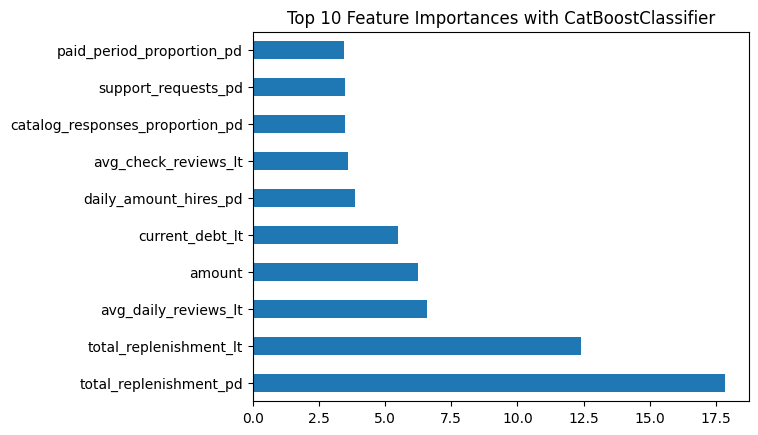

In [66]:
(pd.Series(model.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh'))
plt.title('Top 10 Feature Importances with CatBoostClassifier')

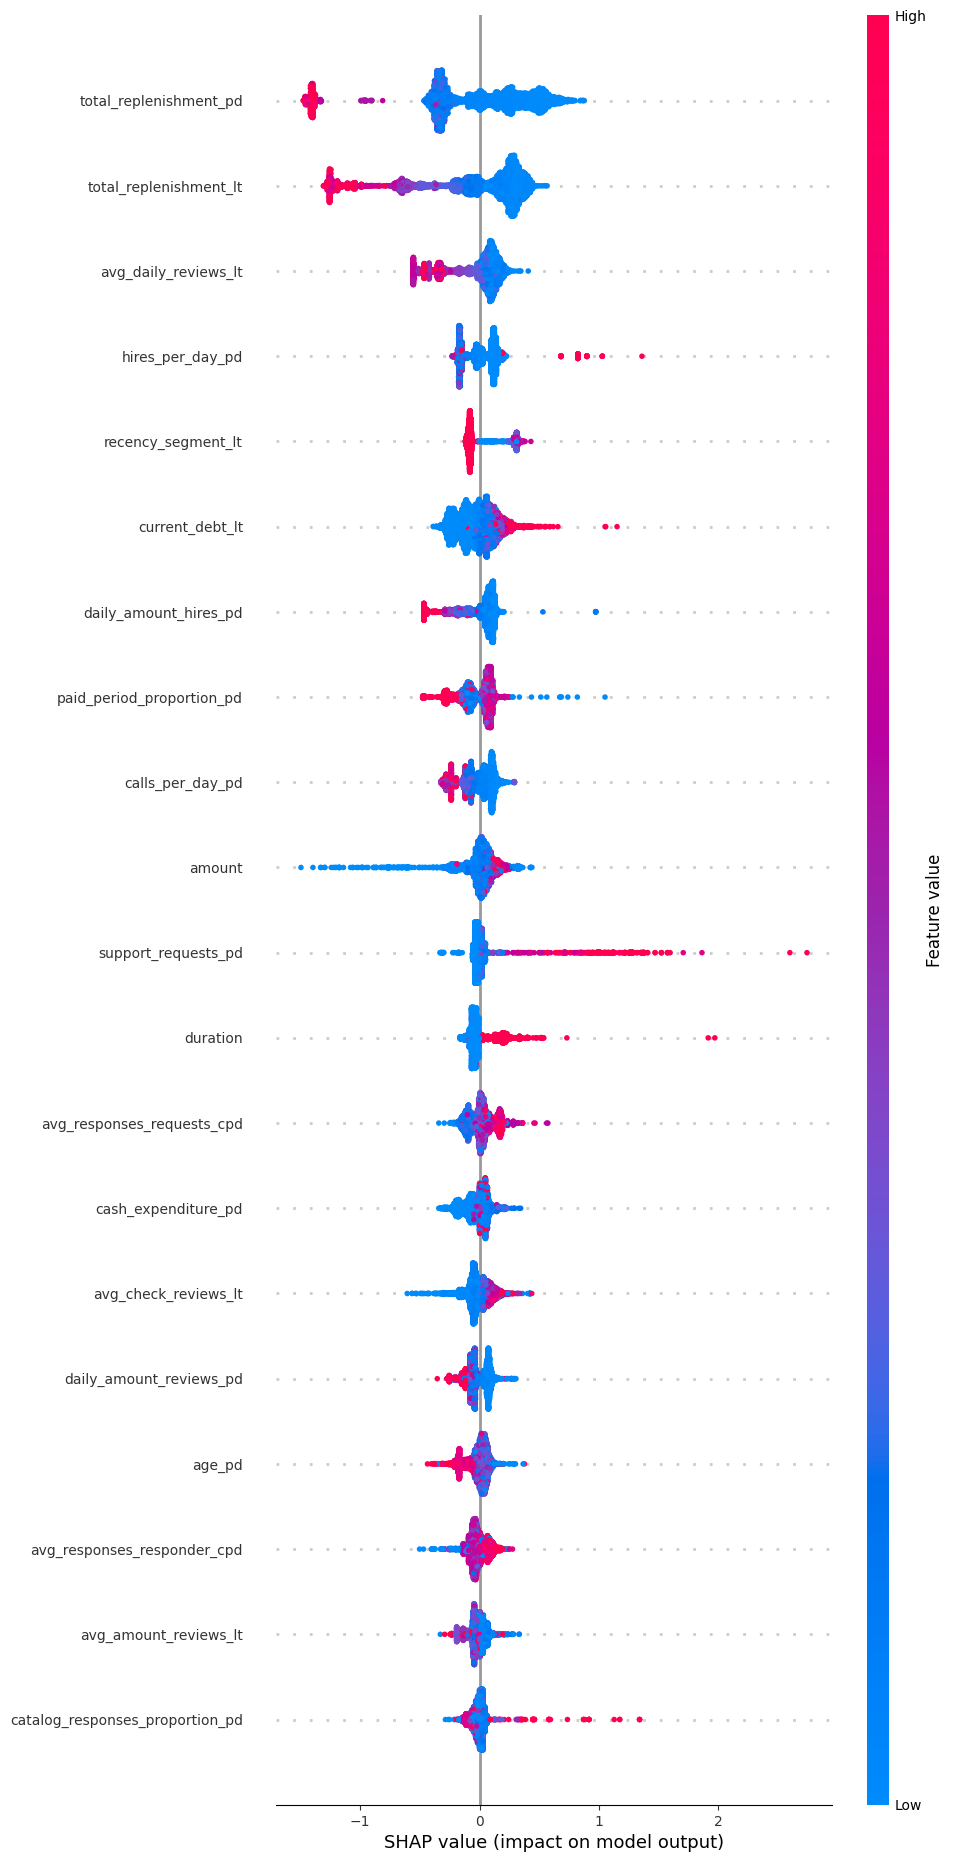

In [23]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_size=(12,8), show=False)
plt.gcf().set_size_inches(10, 20) 

for ax in plt.gcf().axes:
    for label in ax.get_yticklabels() + ax.get_xticklabels():
        label.set_fontsize(10) 
    for line in ax.get_lines():
        line.set_linewidth(2)
    for artist in ax.get_children():
        if isinstance(artist, plt.Text):
            artist.set_size(10)

Описательная статистика для total_replenishment_pd:
count    31837.0000
mean      7309.5937
std      16826.4125
min          0.0000
25%          0.0000
50%          0.0000
75%       7700.0000
max     657600.0000
Name: total_replenishment_pd, dtype: float64

Описательная статистика для total_replenishment_pd после удаления выбросов:
count   31719.0000
mean     6804.0606
std     13184.4774
min         0.0000
25%         0.0000
50%         0.0000
75%      7500.0000
max     90200.0000
Name: total_replenishment_pd, dtype: float64

Описательная статистика для total_replenishment_lt:
count     31837.0000
mean      57243.2886
std      112975.4428
min           0.0000
25%        6000.0000
50%       19000.0000
75%       57983.0000
max     4250670.0000
Name: total_replenishment_lt, dtype: float64

Описательная статистика для total_replenishment_lt после удаления выбросов:
count    31526.0000
mean     49738.0374
std      79340.4977
min          0.0000
25%       5997.0000
50%      18554.5000
75%   

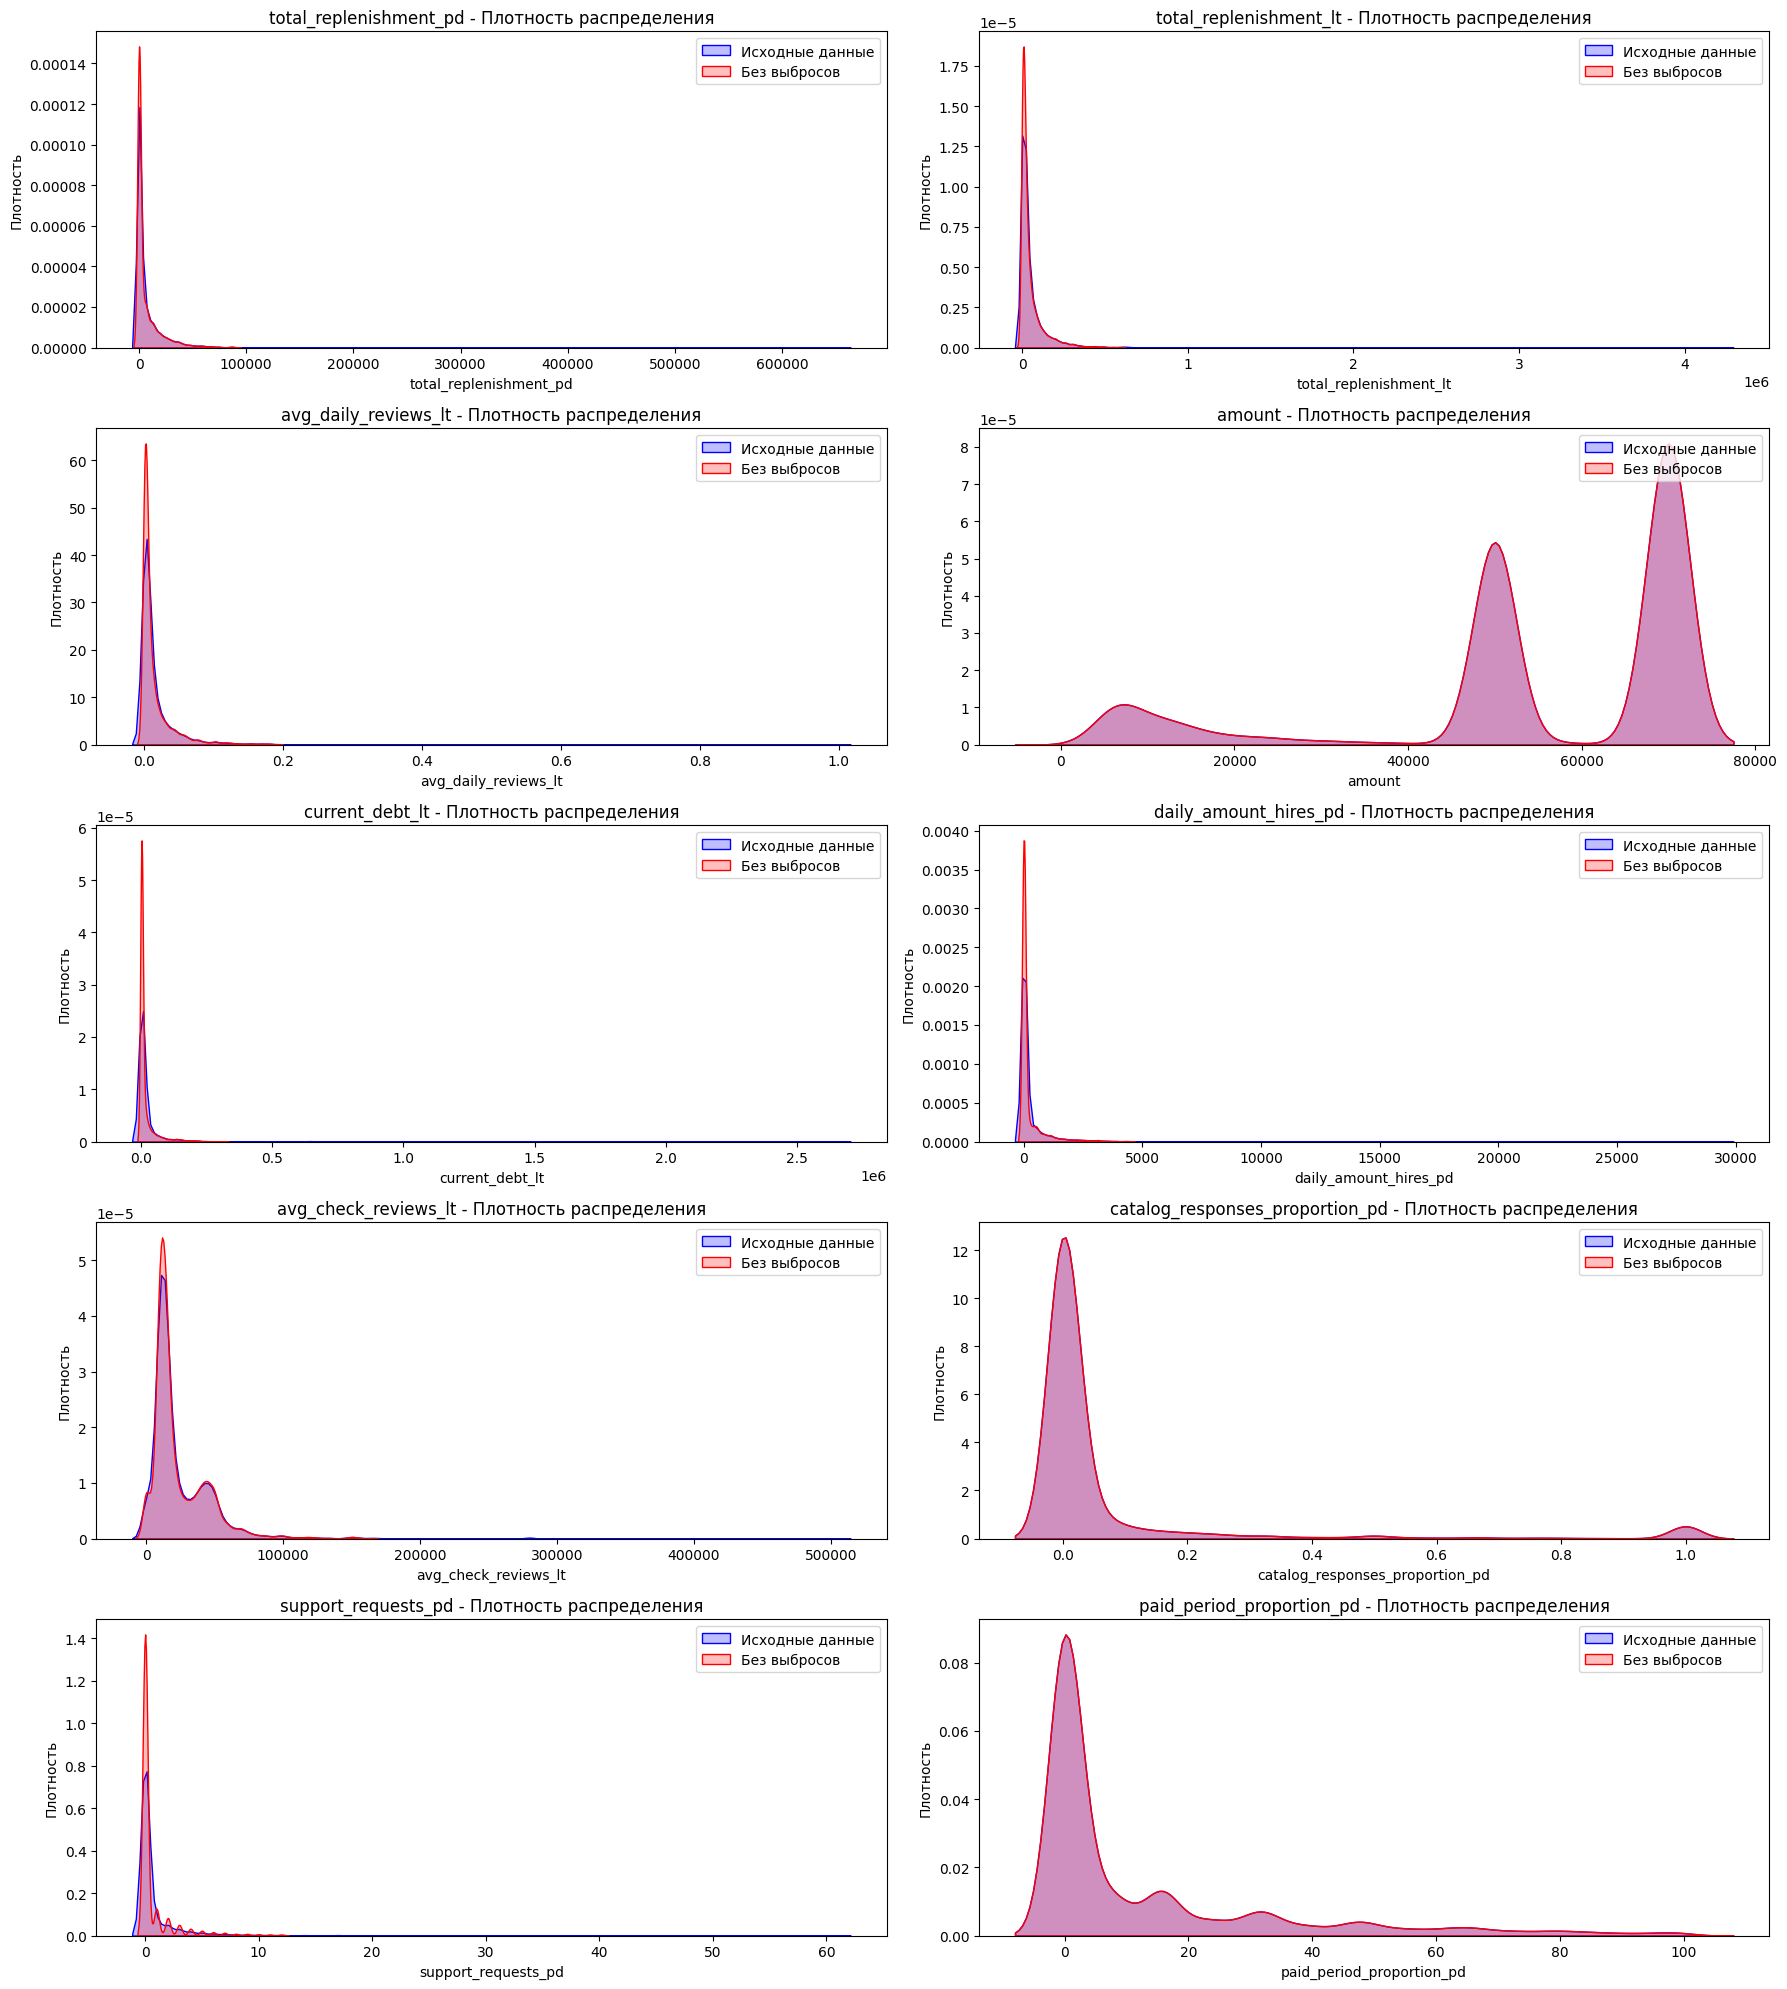

Было удалено 2157 строк (6.78% от исходного размера данных)


In [130]:
top_10_features = pd.Series(model.feature_importances_, index=X_train_cleaned.columns).nlargest(10).index

original_rows = len(df)
removed_rows_total = 0

def remove_outliers(data, feature):
    q1 = data[feature].quantile(0.05)
    q3 = data[feature].quantile(0.95)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    cleaned_data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]
    return cleaned_data

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), dpi=100)
axes = axes.ravel()

for i, feature in enumerate(top_10_features):
    data_cleaned = df.copy()
    
    data_cleaned = remove_outliers(data_cleaned, feature)
    
    sns.kdeplot(df[feature], ax=axes[i], shade=True, color='b', label='Исходные данные')
    sns.kdeplot(data_cleaned[feature], ax=axes[i], shade=True, color='r', label='Без выбросов')
    axes[i].set_title(f"{feature} - Плотность распределения")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')
    axes[i].legend()
    
    print(f"Описательная статистика для {feature}:")
    print(df[feature].describe())
    print()
    print(f"Описательная статистика для {feature} после удаления выбросов:")
    print(data_cleaned[feature].describe())
    print()
    
    removed_rows = original_rows - len(data_cleaned)
    removed_rows_total += removed_rows

plt.tight_layout()
plt.show()

removal_ratio = removed_rows_total / original_rows * 100

print(f"Было удалено {removed_rows_total} строк ({removal_ratio:.2f}% от исходного размера данных)")

Топ 10 категориальных переменных по коэффициенту взаимной информации:
['work_start_date', 'phone_number', 'selected_service_categories_lt', 'data_collection_date', 'installment_status', 'season', 'season_opened', 'base_city_pd', 'gender_lt', 'os_lt']

Распределение категориальных переменных:


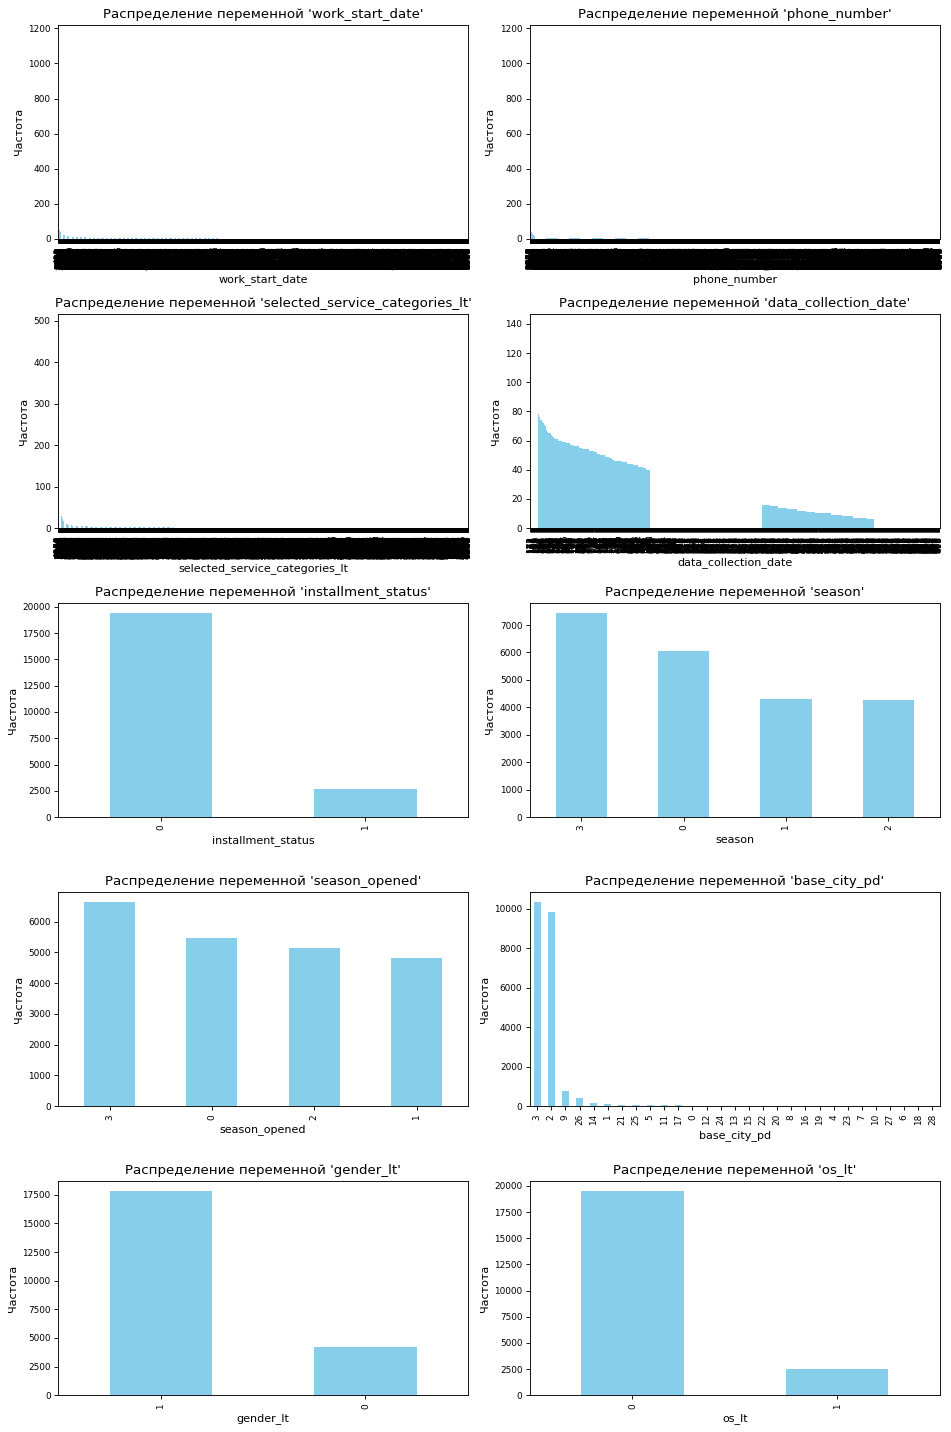

In [85]:
df = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv', low_memory=False)

cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

cat_mi_scores = []
for col in cat_cols:
    mi_score = mutual_info_classif(df[[col]], df['target'])[0]
    cat_mi_scores.append(mi_score)

cat_mi_df = pd.DataFrame({'feature': cat_cols, 'mi_score': cat_mi_scores})

# Выбор топ 10 категориальных переменных по коэффициенту взаимной информации
top_10_cat = cat_mi_df.sort_values('mi_score', ascending=False).head(10)['feature'].tolist()

print("Топ 10 категориальных переменных по коэффициенту взаимной информации:")
print(top_10_cat)

print("\nРаспределение категориальных переменных:")

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 18), dpi=80)
axes = axes.ravel()

for i, col in enumerate(top_10_cat):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f"Распределение переменной '{col}'", fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel("Частота", fontsize=10)
    axes[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()


In [131]:
data.columns

Index(['id', 'ltd', 'ltm', 'data_collection_date', 'work_start_date', 'total_replenishment_lt', 'total_replenishment_pd', 'cash_expenditure_pd', 'services_count_pd', 'phone_number', 'amount', 'duration', 'installment_status', 'npl_days', 'current_installments_sum', 'age_pd', 'gender_lt', 'base_city_pd', 'os_lt', 'current_debt_lt', 'nps_lt', 'selected_service_categories_lt', 'support_requests_pd', 'recency_segment_lt', 'monetary_segment_lt', 'frequency_segment_lt', 'avg_check_reviews_lt', 'avg_daily_reviews_lt', 'avg_amount_reviews_lt', 'rating_reviews_lt', 'avg_check_categories_pd', 'avg_check_reviews_pd', 'responses_per_day_pd', 'connects_per_day_pd', 'calls_per_day_pd', 'hires_per_day_pd', 'review_requests_per_day_pd', 'reviews_per_day_pd', 'daily_amount_responses_pd', 'daily_amount_connects_pd', 'daily_amount_calls_pd', 'daily_amount_hires_pd', 'daily_amount_review_requests_pd', 'daily_amount_reviews_pd', 'rating_reviews_pd', 'avg_responses_requests_cpd',
       'avg_responses_respo